In [2]:
# %% [markdown]
# ## Setup Environment
# Import dependencies, verify project structure, and set up device.

# %% [code]
import torch
import torch.optim as optim
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

try:
    import import_ipynb
except ModuleNotFoundError:
    print("Installing import_ipynb...")
    !pip install import_ipynb
    import import_ipynb

print(f"Current working directory: {os.getcwd()}")
if not os.getcwd().endswith("CodeBase"):
    print("Warning: Current directory is not CodeBase/. Ensure notebook is run from CodeBase/")
sys.path.append(os.getcwd())

# Verify directory structure
required_dirs = ["src/preprocessing", "src/models", "src/training", "src/evaluation"]
for d in required_dirs:
    if not os.path.exists(d):
        raise FileNotFoundError(f"{d} directory not found in CodeBase/. Ensure it exists.")

# Verify preprocessing and training files
preprocessing_files = ["data_collection.ipynb", "normalize.ipynb", "dataset.ipynb"]
training_files = ["train_hybrid.ipynb", "train_cnn.ipynb", "train_rnn.ipynb"]
for f in preprocessing_files:
    if not os.path.exists(os.path.join("src/preprocessing", f)):
        raise FileNotFoundError(f"{f} not found in src/preprocessing/")
for f in training_files:
    if not os.path.exists(os.path.join("src/training", f)):
        raise FileNotFoundError(f"{f} not found in src/training/")
print(f"Files in src/preprocessing/: {os.listdir('src/preprocessing')}")
print(f"Files in src/training/: {os.listdir('src/training')}")

# Import modules
try:
    from src.preprocessing.data_collection import create_synthetic_dataset
    from src.preprocessing.normalize import normalize_dataset
    from src.preprocessing.dataset import get_dataloaders
    from src.models.hybrid_model import HybridModel
    from src.models.cnn_model import CNNModel
    from src.models.rnn_model import RNNModel
    from src.training.train_hybrid import train_hybrid
    from src.training.train_cnn import train_cnn
    from src.training.train_rnn import train_rnn
    from src.evaluation.evaluate import evaluate_hybrid, evaluate_cnn, evaluate_rnn, visualize_predictions
    print("All modules imported successfully")
except ImportError as e:
    print(f"Import error: {e}")
    print("Ensure all .ipynb and .py files exist and are valid in src/preprocessing/, src/training/, src/models/, and src/evaluation/")
    raise

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
os.makedirs("outputs/models", exist_ok=True)
os.makedirs("outputs/visualizations", exist_ok=True)

Current working directory: /Users/lakmalprasanna/Documents/University/Research/CodeBase
Files in src/preprocessing/: ['dataset.ipynb', 'data_collection.ipynb', '__init__.py', '__pycache__', 'normalize.ipynb', '.ipynb_checkpoints']
Files in src/training/: ['train_cnn.ipynb', '__init__.py', '__pycache__', 'train_hybrid.ipynb', '.ipynb_checkpoints', 'train_rnn.ipynb']
All modules imported successfully
Using device: cpu


In [3]:
# %% [markdown]
# ## Generate Synthetic Data
# Generate synthetic Sinhala character images using a font, saving each character in its own subfolder with English alias.

# %% [code]
import os
# Update with the actual path to the font file
font_path = "fonts/sinhala.ttf"
# Verify font file exists
if not os.path.exists(font_path):
    raise FileNotFoundError(f"Font file not found at {font_path}. Please download NotoSerifSinhala-Regular.ttf and update the path.")
# List of 14 Sinhala vowels
sinhala_chars = ["අ", "ආ", "ඇ", "ඈ", "ඉ", "ඊ", "උ", "ඌ", "එ", "ඒ", "ඓ", "ඔ", "ඕ", "ඖ"]
from src.preprocessing.data_collection import create_synthetic_dataset
# Create synthetic data
output_dir = "data/synthetic/"
create_synthetic_dataset(font_path, output_dir, sinhala_chars, samples_per_char=100)
# Verify output
print(f"Synthetic data generated in {output_dir} with character-specific subfolders")
print(f"Subfolders created: {os.listdir(output_dir) if os.path.exists(output_dir) else 'No subfolders'}")

Synthetic data generated in data/synthetic/ with character-specific subfolders
Subfolders created: ['uu', 'ae', 'ii', 'ee', 'u', 'i', 'A', 'o', 'ai', 'au', 'aa', 'oo', 'e']


In [4]:
# %% [markdown]
# ## Normalize Images
# Normalize synthetic images from character-specific subfolders and real images to grayscale 64x64.

# %% [code]
import os
from src.preprocessing.normalize import normalize_dataset
# Input directories
synthetic_dir = "data/synthetic/"
real_dir = "data/real/"
output_dir = "data/normalized/"
# Verify input directories
print(f"Synthetic dir exists: {os.path.exists(synthetic_dir)}, Contents: {os.listdir(synthetic_dir) if os.path.exists(synthetic_dir) else 'Empty'}")
print(f"Real dir exists: {os.path.exists(real_dir)}, Contents: {os.listdir(real_dir) if os.path.exists(real_dir) else 'Empty'}")
# Normalize synthetic images from subfolders
if os.path.exists(synthetic_dir):
    for char_folder in os.listdir(synthetic_dir):
        char_path = os.path.join(synthetic_dir, char_folder)
        if os.path.isdir(char_path):
            normalize_dataset(char_path, output_dir)
# Normalize real images
if os.path.exists(real_dir):
    normalize_dataset(real_dir, output_dir)
# print(f"Normalized images saved in {output_dir}")
# print(f"Output dir contents: {os.listdir(output_dir) if os.path.exists(output_dir) else 'Empty'}")

Synthetic dir exists: True, Contents: ['uu', 'ae', 'ii', 'ee', 'u', 'i', 'A', 'o', 'ai', 'au', 'aa', 'oo', 'e']
Real dir exists: True, Contents: []


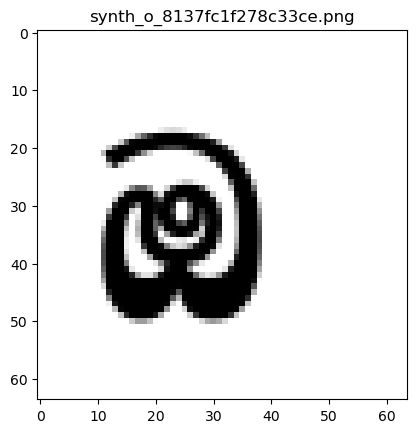

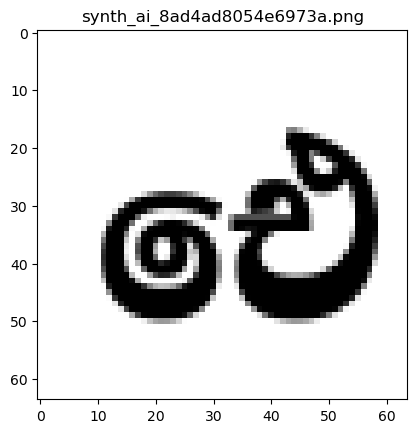

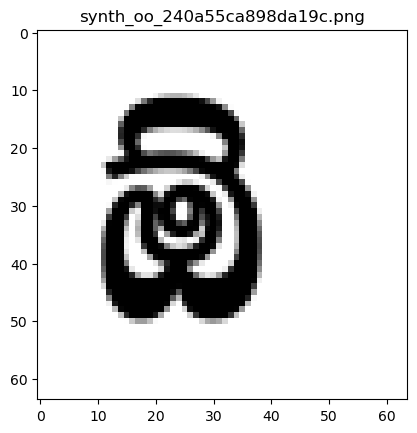

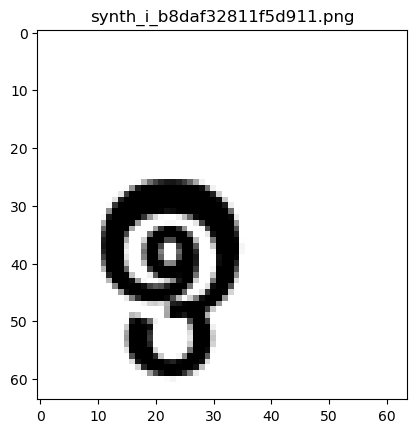

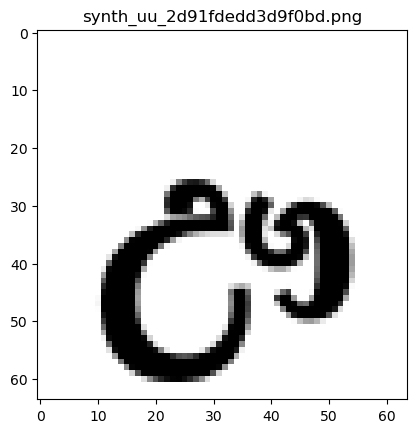

In [5]:
# %% [markdown]
# ## Verify Preprocessing
# Visualize a few normalized images to ensure quality.

# %% [code]
from PIL import Image
sample_images = [f for f in os.listdir("data/normalized/") if f.endswith('.png')][:5]
for img_name in sample_images:
    img = Image.open(os.path.join("data/normalized/", img_name))
    plt.imshow(img, cmap='gray')
    plt.title(img_name)
    plt.show()

In [6]:
# %% [markdown]
# ## Create DataLoaders
# Load normalized images into PyTorch DataLoaders for training, validation, and testing.

# %% [code]
train_loader, val_loader, test_loader, char_to_idx = get_dataloaders("data/normalized", batch_size=32)
print(f"Dataset size: {len(train_loader.dataset) + len(val_loader.dataset) + len(test_loader.dataset)}")
print(f"Number of characters: {len(char_to_idx)}")

Dataset size: 4200
Number of characters: 1400


In [7]:
# %% [markdown]
# ## Initialize Models
# Create instances of the hybrid, CNN, and RNN models.

# %% [code]
import torch.optim as optim  # Ensure optim is imported
num_chars = len(char_to_idx) + 1  # 1401 for HybridModel and RNNModel (with blank token)
print(f"Number of classes for HybridModel and RNNModel: {num_chars}")
num_chars_cnn = len(char_to_idx)  # 1400 for CNNModel (no blank token)
print(f"Number of classes for CNNModel: {num_chars_cnn}")
hybrid_model = HybridModel(num_chars).to(device)
cnn_model = CNNModel(num_chars_cnn).to(device)
rnn_model = RNNModel(input_size=64*64, num_chars=num_chars).to(device)
optimizer_hybrid = optim.Adam(hybrid_model.parameters(), lr=0.001)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=0.001)
print("Models initialized")

Number of classes for HybridModel and RNNModel: 1401
Number of classes for CNNModel: 1400
Models initialized


In [8]:
# %% [markdown]
# ## Train Hybrid Model
# Train the CNN-RNN hybrid model with CTC loss.

# %% [code]
try:
    hybrid_model = train_hybrid(hybrid_model, train_loader, val_loader, device, optimizer_hybrid, epochs=10)
    torch.save(hybrid_model.state_dict(), "outputs/models/hybrid_model.pth")
    print("Hybrid model trained and saved")
except Exception as e:
    print(f"Error training hybrid model: {e}")

Number of classes: 1401
Epoch 1, Batch 0, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1, 1401])
Epoch 1, Batch 1, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1, 1401])
Epoch 1, Batch 2, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1, 1401])
Epoch 1, Batch 3, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1, 1401])
Epoch 1, Batch 4, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1, 1401])
Epoch 1, Batch 5, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1, 1401])
Epoch 1, Batch 6, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1, 1401])
Epoch 1, Batch 7, Image 

In [9]:
# %% [markdown]
# ## Train CNN Model
# Train the standalone CNN model with cross-entropy loss.

# %% [code]
cnn_model = train_cnn(cnn_model, train_loader, val_loader, device, optimizer_cnn, epochs=10)
torch.save(cnn_model.state_dict(), "outputs/models/cnn_model.pth")
print("CNN model trained and saved")

Number of classes: 1400
Epoch 1, Batch 0, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1400])
Epoch 1, Batch 1, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1400])
Epoch 1, Batch 2, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1400])
Epoch 1, Batch 3, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1400])
Epoch 1, Batch 4, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1400])
Epoch 1, Batch 5, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1400])
Epoch 1, Batch 6, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1400])
Epoch 1, Batch 7, Image shape: torch.Size([32

In [10]:
# %% [markdown]
# ## Train RNN Model
# Train the standalone RNN model with CTC loss.

# %% [code]
try:
    rnn_model = train_rnn(rnn_model, train_loader, val_loader, device, optimizer_rnn, epochs=10)
    torch.save(rnn_model.state_dict(), "outputs/models/rnn_model.pth")
    print("RNN model trained and saved")
except Exception as e:
    print(f"Error training RNN model: {e}")

Number of classes: 1401
Epoch 1, Batch 0, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1, 1401])
Epoch 1, Batch 1, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1, 1401])
Epoch 1, Batch 2, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1, 1401])
Epoch 1, Batch 3, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1, 1401])
Epoch 1, Batch 4, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1, 1401])
Epoch 1, Batch 5, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1, 1401])
Epoch 1, Batch 6, Image shape: torch.Size([32, 1, 64, 64]), Label shape: torch.Size([32])
Model output shape: torch.Size([32, 1, 1401])
Epoch 1, Batch 7, Image 

In [11]:
# %% [markdown]
# ## Evaluate Hybrid Model
# Compute CER, WER, and accuracy for the hybrid model.

# %% [code]
try:
    cer, wer, accuracy = evaluate_hybrid(hybrid_model, test_loader, char_to_idx, device)
    print(f"Hybrid Model - CER: {cer:.4f}, WER: {wer:.4f}, Accuracy: {accuracy:.4f}")
except Exception as e:
    print(f"Error evaluating Hybrid model: {e}")

Evaluate HybridModel - Output shape: torch.Size([32, 1, 1401]), Label shape: torch.Size([32])
Evaluate HybridModel - Output shape: torch.Size([32, 1, 1401]), Label shape: torch.Size([32])
Evaluate HybridModel - Output shape: torch.Size([32, 1, 1401]), Label shape: torch.Size([32])
Evaluate HybridModel - Output shape: torch.Size([32, 1, 1401]), Label shape: torch.Size([32])
Evaluate HybridModel - Output shape: torch.Size([12, 1, 1401]), Label shape: torch.Size([12])
Hybrid Model - CER: 0.6431, WER: 1.0000, Accuracy: 0.0000


In [12]:
# %% [markdown]
# ## Evaluate CNN Model
# Compute accuracy for the CNN model.

# %% [code]
try:
    accuracy = evaluate_cnn(cnn_model, test_loader, char_to_idx, device)
    print(f"CNN Model - Accuracy: {accuracy:.4f}")
except Exception as e:
    print(f"Error evaluating CNN model: {e}")

Evaluate CNNModel - Output shape: torch.Size([32, 1400]), Label shape: torch.Size([32])
Evaluate CNNModel - Output shape: torch.Size([32, 1400]), Label shape: torch.Size([32])
Evaluate CNNModel - Output shape: torch.Size([32, 1400]), Label shape: torch.Size([32])
Evaluate CNNModel - Output shape: torch.Size([32, 1400]), Label shape: torch.Size([32])
Evaluate CNNModel - Output shape: torch.Size([12, 1400]), Label shape: torch.Size([12])
CNN Model - Accuracy: 0.0000


In [13]:
# %% [markdown]
# ## Evaluate RNN Model
# Compute CER, WER, and accuracy for the RNN model.

# %% [code]
try:
    cer, wer, accuracy = evaluate_rnn(rnn_model, test_loader, char_to_idx, device)
    print(f"RNN Model - CER: {cer:.4f}, WER: {wer:.4f}, Accuracy: {accuracy:.4f}")
except Exception as e:
    print(f"Error evaluating RNN model: {e}")

Evaluate RNNModel - Output shape: torch.Size([32, 1, 1401]), Label shape: torch.Size([32])
Evaluate RNNModel - Output shape: torch.Size([32, 1, 1401]), Label shape: torch.Size([32])
Evaluate RNNModel - Output shape: torch.Size([32, 1, 1401]), Label shape: torch.Size([32])
Evaluate RNNModel - Output shape: torch.Size([32, 1, 1401]), Label shape: torch.Size([32])
Evaluate RNNModel - Output shape: torch.Size([12, 1, 1401]), Label shape: torch.Size([12])
RNN Model - CER: 0.6608, WER: 1.0000, Accuracy: 0.0000


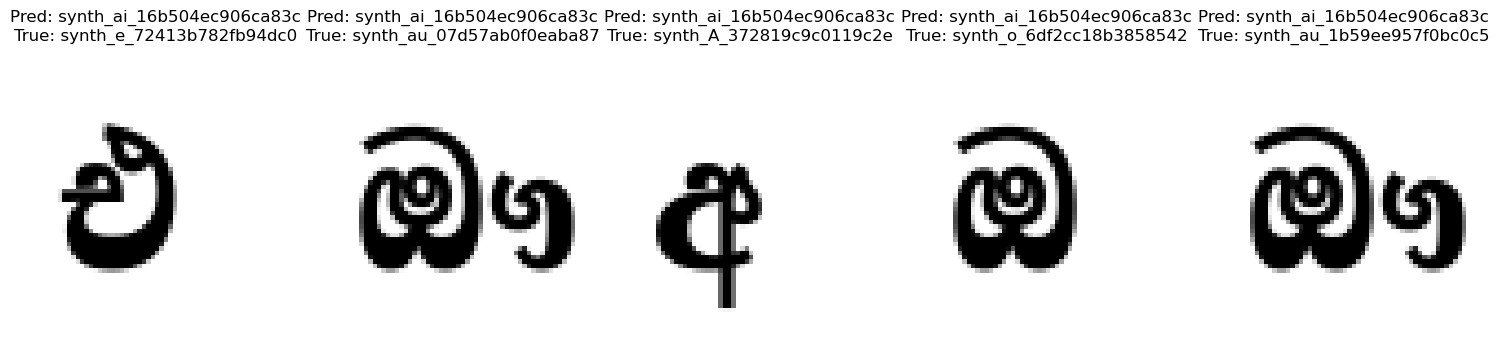

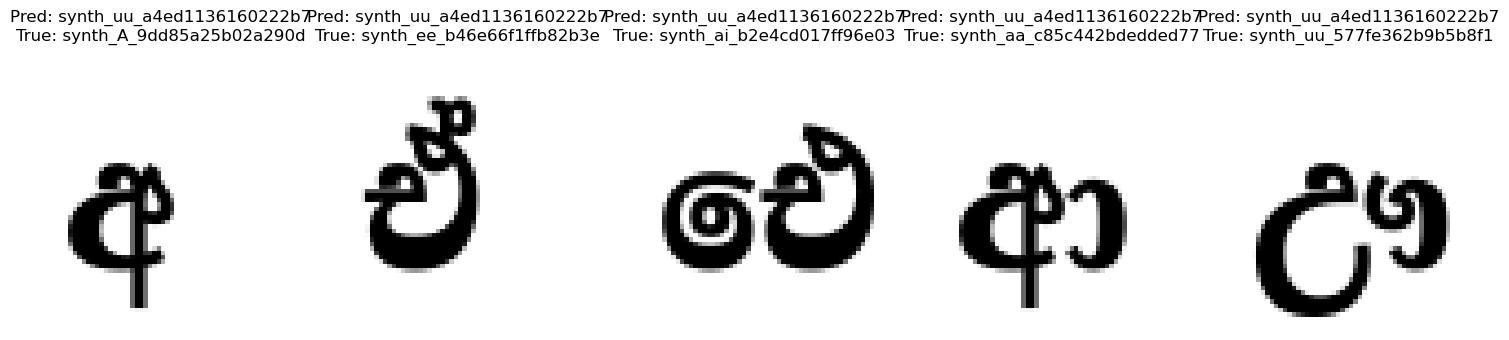

Visualizations saved in outputs/visualizations/


In [14]:
# %% [markdown]
# ## Visualize Predictions
# Generate and display sample predictions for hybrid and RNN models.

# %% [code]
visualize_predictions(hybrid_model, test_loader, char_to_idx, device, num_samples=5)
visualize_predictions(rnn_model, test_loader, char_to_idx, device, num_samples=5)
print("Visualizations saved in outputs/visualizations/")